## <font color=blue >DAN demo.
This notebook demos how to train the DAN model on the CSV dataset files of ***SFC*** stream sensor. If you want to run it on other sensors, just change the parameter of ***--stream_sensor*** and ***--rain_sensor***.

In our dataset, the parameters should be set to:

--stream_sensor **Ross_S_fixed**
--rain_sensor **Ross_R_fixed** 

--stream_sensor **Saratoga_S_fixed** 
--rain_sensor **Saratoga_R_fixed** 

--stream_sensor **UpperPen_S_fixed** 
--rain_sensor **UpperPen_R_fixed** 

--stream_sensor **SFC_S_fixed** 
--rain_sensor **SFC_R_fixed** 

With DAN, you can build **uni-variate** model, which means you only have stream sensor data as the traininig data and the input to the model.

Also, you can build **multi-variate** model, which means you have stream sensor data and nearby rain sensor data. In this situation, the rain data can be the real rain record and the predicted rain data. 
    
Generally, the **predicted rain data** can be extended to the future days, which will be a good hint to help forecast the stream data. So if you have influent forecasted data to train the model, please think about adoping this since we can support this method by setting the parameter *r_shift* to make use of the future forecasted rain information.

## <font color=blue >Parameter setting. 

--**stream_sensor**: stream dataset file name. The file should be csv file.

--**rain_sensor**: rain dataset file name. The file should be csv file.

--**train_volume**: train set size.

--**hidden_dim**: hidden dim of lstm layers.

--**cnn_dim**: hidden dim of cnn layers.

--**layer**: number of layers.

--**stack_types**: model stacks specified for this sensor. It should be a stack of encoder, decoder and residue.

--**r_shift**: shift positions of rain hinter, set to 288 without any predicted rain value. Otherwise, set to 0~288 according to the length of known forecasted rain data.

--**watershed**: 1 if trained with rain info, else 0.

--**model**: model name, used to generate the pt file and predicted file names.

--**mode**: set it to 'train' or 'inference' with an existing pt_file.

--**pt_file**: if set, the model will be loaded from this pt file, otherwise check the file according to the assigned parameters.

--**save**: if save the predicted file of testset, set to 1, else 0.

--**outf**: default value is './output', the model will be saved in the train folder in this directory.

## <font color=blue >Train a *uni-variate* model without rain data.

In [ ]:
! python run.py \
--stream_sensor SFC_S_fixed \
--rain_sensor SFC_R_fixed \
--model SFC_noRain \
--mode train \
--watershed 0 \
--r_shift 288 \
--stack_types '"encoder","decoder","encoder","decoder","residue"' \
--train_volume 30000 \
--hidden_dim 384 \

## <font color=blue >Train a *multi-variate* model with rain data.

In [ ]:
! python run.py \
--stream_sensor SFC_S_fixed \
--rain_sensor SFC_R_fixed \
--model SFC_withRain \
--mode train \
--watershed 1 \
--r_shift 0 \
--stack_types '"encoder","decoder","encoder","decoder","residue"' \
--train_volume 30000 \
--hidden_dim 384 \

## <font color=blue >Train a *multi-variate* model using forecasted rain data.

In [ ]:
! python run.py \
--stream_sensor SFC_S_fixed \
--rain_sensor SFC_R_fixed \
--model SFC_withRain_shift \
--mode train \
--watershed 1 \
--r_shift 0 \
--stack_types '"encoder","decoder","residue"' \
--train_volume 20000 \
--hidden_dim 512 \

## <font color=blue >Load a trained multi-variate model.

In [ ]:
import numpy as np
import random
import imp
from utils.utils2 import *
from run import Options
from models.DAN_M import *
pt = './output/SFC_withRain_shift/train/SFC_withRain.zip'
# get model
model = Options().get_model(pt)

## <font color=blue >Use test_single to do inferencing on one time-point.

RMSE:  139.66732135095194
MAPE:  0.3246788859493147


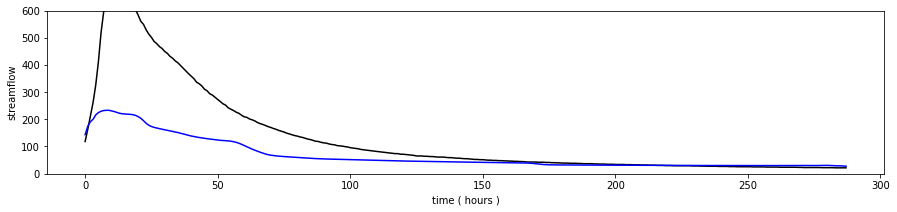

In [2]:
import numpy as np
from utils.utils2 import *
testP=["2021-12-16 00:30:00" ] 
predicted, ground_truth = model.test_single(testP[0])
print("RMSE: ", RMSE(predicted, ground_truth))
print("MAPE: ", MAPE(predicted, ground_truth))
plot(ground_truth, predicted)

## <font color=blue >Load a trained multi-variate model with forecasted rain data.

In [2]:
import numpy as np
import random
import imp
from utils.utils2 import *
from run import Options
from models.DAN_M import *
pt = './output/SFC_withRain_shift/train/SFC_withRain_shift.zip'
# get model
model = Options().get_model(pt)

current dir:  /data/hydro/hydro-2/code/DAN_pure_code_1211
Importing parameters from:  opt.txt ............
| DANet
| --  Stack Encoder (#0)
| --  Stack Decoder (#1)
| --  Stack Residue (#2)
norm is:  [1.38939955e+00 1.42360186e+00 7.20744940e-04 7.35950598e-03]


## <font color=blue >Inferencing for one time point.
If you already have test time point, use ***test_single*** function to do it, assuming stream input and rain data input can be retrieved from the dataset. 

test_point is:  2021-12-16 00:30:00
RMSE:  66.66635489349483
MAPE:  0.5394172786215025


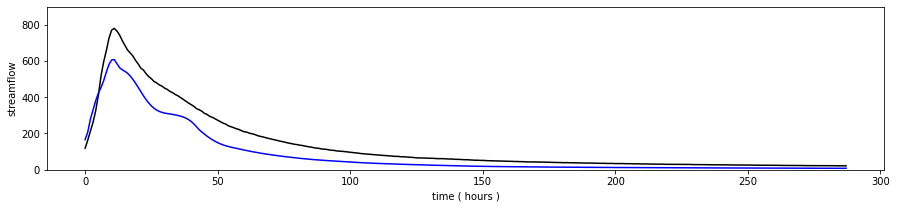

In [3]:
import numpy as np
from utils.utils2 import *
testP=["2021-12-16 00:30:00" ]
predicted, ground_truth = model.test_single(testP[0])
print("RMSE: ", RMSE(predicted, ground_truth))
print("MAPE: ", MAPE(predicted, ground_truth))
plot(ground_truth, predicted)

## <font color=blue >Inferencing for real-world application.
If you already have test time point, history stream input and rain data input prepared, use ***predict*** function to do it.

In [4]:
import numpy as np
import random
from utils.utils2 import *
from run import Options
from models.DAN_M import *
from models.Inference import *
opt = Options().parse()
# model name
pt = './output/SFC_withRain_shift/train/SFC_withRain_shift.zip'
# get model
model = Options().get_model(pt)
# get data
testP=["2021-12-16 00:30:00"]   
for i in range(len(testP)):
    stream_data, indicator_data, _ = model.get_data(testP[i])  
    p = model.predict(testP[i], stream_data, indicator_data)
    print("Predicted data: ")
    print(p)

current dir:  /data/hydro/hydro-2/code/DAN_pure_code_1211
Importing parameters from:  opt.txt ............
| DANet
| --  Stack Encoder (#0)
| --  Stack Decoder (#1)
| --  Stack Residue (#2)
norm is:  [1.38939955e+00 1.42360186e+00 7.20744940e-04 7.35950598e-03]
test_point is:  2021-12-16 00:30:00
Predicted data: 
[165.2791251  208.51392551 279.93059408 329.75679548 381.22430562
 422.88107829 453.75106156 491.68966003 538.9351681  581.04373245
 606.31477918 607.80486723 585.52600254 563.13089949 551.49196065
 543.07285008 532.31545812 517.24193894 498.91645038 477.87196649
 454.99340857 431.05126495 407.67152756 386.62877914 367.99245666
 351.70507214 338.57920298 328.73050912 321.38291222 315.96447951
 312.23117053 309.6260827  307.46597588 305.20425915 302.49965476
 299.24129154 295.45691885 290.73047864 284.47760392 276.32899611
 266.03578866 252.73226336 236.32983466 220.56439571 207.55413055
 195.83403891 184.71275158 174.33738217 164.86494039 156.37566955
 148.87063289 142.3096417